<a href="https://colab.research.google.com/github/jamienkp/COMP6781/blob/main/Assignment%201/COMP6781_A1_JamieNg_40336644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assigment 1: Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [ ]:
!pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import torch
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this assigment we will use the dataset *text8*. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [ ]:
import gensim.downloader as api

dataset = list(api.load("text8"))[0:200] #We trim the dataset to make training as long. Feel free to change this based on your resources

Let's have a look at a datapoint.

In [ ]:
(" ").join(dataset[0])

In [ ]:
print(dataset)

Normally we would need to do some data preprocessing in order to clean our dataset but lucky for you the professor chose a pretty and clean dataset so you don't have to 😉

Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
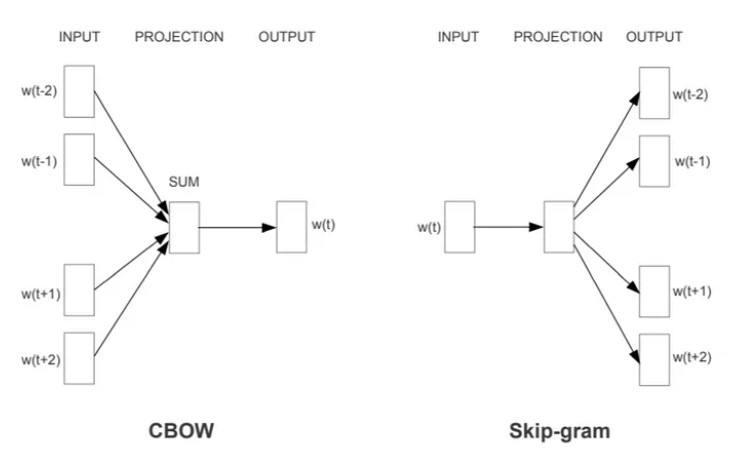

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the one hot encodings to represent the words, so we will need the mapping: word -> one-hot-encoding

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F

def create_word_to_index(vocab_list):
  """ Method that creates dictionary that maps words to an index.
  Arguments
  ---------
  vocab_list : list(String)
    List of words in the vocabulary
  Returns
  -------
  word_to_index : Dictionary
    Dictionary mapping words to index with format {word:index}
  """
  # TODO Write code that associates every word to a specific index. IMPORTANT: Remember to add the token OOV for words out of vocabulary

  word2index = {'OOV': 0}

  for i, word in enumerate(vocab_list, start=1):
    word2index[word] = i


  return word2index

all_words = [word for sentence in dataset for word in sentence]

vocab_list = list(set(all_words))
word_to_index = create_word_to_index(vocab_list)


print("Vocab list: ", vocab_list)
print("Word to index: ", word_to_index)


In [ ]:
def generate_dataset(dataset, window_size,word_to_index):


  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings = []
  targets = []

  # TODO complete the following
  for i in dataset:

      words = i

      if len(words) < 2 * window_size + 1:
          continue

      for i in range(window_size,len(words)-window_size):

        context_words = words[i - window_size:i] + words[i + 1:i + window_size + 1]
        #get indexes of surrounding words in a list
        surrounding = [word_to_index.get(w, word_to_index["OOV"]) for w in context_words]
        surrounding = torch.tensor(surrounding)
        #get index of target word
        target =  word_to_index.get(words[i], word_to_index["OOV"])
        surroundings.append((surrounding))
        targets.append(target)

  # Convert lists to tensors
  surroundings = torch.stack(surroundings)
  targets = torch.tensor(targets)

  return surroundings, targets


WINDOW_SIZE = 2
surroundings, targets = generate_dataset(dataset, WINDOW_SIZE, word_to_index)

print(surroundings.shape)
print(targets.shape)


With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [ ]:
import torch.nn as nn
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

    # Linear layer that encodes one-hot-encoding to embedding dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_in = nn.Linear(vocab_size, embed_dim, bias=False)
    #  Linear layer that decodes from embedding dimension to vocab dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_out = nn.Linear(embed_dim, vocab_size, bias=False)


  def forward(self, x):
    #pass input through embedding layer
    emb = self.linear_in(x)
    #average embeddings
    average = emb.mean(dim=1)
    #pass through linear layer
    out = self.linear_out(average)

    return out

We will need an important function that creates one hot encoding vectors based on our surrounding word's indexes

In [ ]:
def one_hot_from_surroundings(surroundings,window_size, vocab_size):
  """ Method to create one hot encodings for the surrounding words.
  Arguments
  ---------
  surroundings : N x (Wx2) Tensor
     Tensor with index of surrounding words, with N being the number of samples and W being the window size
  vocab_size : int
     Size of the vocabulary
  Returns
  -------
  one_hot_surroundings : N x (Wx2) x V Tensor
      Tensor with one hot encodings of surrounding words, with N being the number of samples, W being the window size and V being the vocabulary size
  """
  # TODO write function

  # surrounding is a samples of words that is around the target
  one_hot_surr = []
  for surr in surroundings:
    # for each surround
    surr_one_hot = []
    for word in surr:
      # for each word in each surround
      one_hot = torch.zeros(vocab_size, device=device)    # initialise one hot as 0 with the size of vocab size
      one_hot[word] = 1
      surr_one_hot.append(one_hot)
    one_hot_surr.append(torch.stack(surr_one_hot))

  return torch.stack(one_hot_surr)

In [ ]:
#Check if your previous function is correct
index= [[2,3,7,8],[0,1,9,5]]
index_tensor = torch.tensor(index).to(device)
answer = torch.tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]], device=device)

prediction = one_hot_from_surroundings(index_tensor,2,10)
assert prediction.shape == torch.Size([2, 4, 10]), "Make sure the result has shape NUM_EXAMPLES X WINDOW_SIZE*2 X VOCAB_SIZE"
assert torch.equal(prediction,answer), "Wrong implementation of one_hot_from_surroundings method"
print("Good Job!")

Now we are finally ready to train

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
#creation of dataloader for training
full_dataset = list(zip(surroundings,targets))
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)
val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=False) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)



In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
EMB_DIM = 300
CBOW_MODEL = CBOW(len(word_to_index), embed_dim= EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
EPOCHS = 1 #Question1

#BE PATIENT: This code can take up to 1 hours for a batch size of 512 and 1 epochs

def train_model(model, train_loader, val_loader, epochs=1, lr=1e-3): #Question1
    model.train()
    total_loss = 0.0

    for surr, tar in tqdm(train_dataloader, "Training"):
        surr = surr.to(device)
        tar  = tar.to(device)

        # N x (2*W) x V one-hot tensor
        one_hot_surr = one_hot_from_surroundings(
            surr, WINDOW_SIZE, vocab_size=len(word_to_index)
        ).to(device)

        optimizer.zero_grad()
        #  N x V
        logits = model(one_hot_surr)
        loss = loss_function(logits, tar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)


def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for surr, tar in tqdm(val_loader, "Validation"):
            surr = surr.to(device)
            tar  = tar.to(device)

            one_hot_surr = one_hot_from_surroundings(
                surr, WINDOW_SIZE, vocab_size=len(word_to_index)
            ).to(device)

            logits = model(one_hot_surr)
            loss = loss_function(logits, tar)
            total_loss += loss.item()

    return total_loss / len(val_loader)



for epoch in range(EPOCHS):
  train_loss = train_model(CBOW_MODEL, train_dataloader, val_dataloader, epochs=1, lr=0.001)
  val_loss = evaluate_model(CBOW_MODEL, val_dataloader)
  print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
# save model with epoch 5
# torch.save(CBOW_MODEL.state_dict(), "/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_model_weights_with_epoch5.pth")

# save model with epochs 6›
# torch.save(CBOW_MODEL.state_dict(), "/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_model_weights_with_epoch6.pth")





In [ ]:
# RUN ONLY ONCE

# torch.save({
#     'epoch': epoch,
#     'model_state_dict': CBOW_MODEL.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': train_loss,
#     'word_to_index': word_to_index,
# }, "/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_checkpoint_epoch5.pth")


In [ ]:
 checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_checkpoint_epoch5.pth", map_location=device)

 CBOW_MODEL = CBOW(len(checkpoint['word_to_index']), embed_dim=300).to(device)
 CBOW_MODEL.load_state_dict(checkpoint['model_state_dict'])

 optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
 optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

 word_to_index = checkpoint['word_to_index']
 epoch = checkpoint['epoch']
 train_loss = checkpoint['loss']

 print(f"Loaded model trained up to epoch {epoch} with loss {train_loss:.4f}")


## Let's test it!

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [ ]:
VOCAB_SIZE = len(word_to_index)

def create_word_to_embedding(vocab_list, model, word_to_index):
    """ Method to get create dictionary that maps a word to it's embedding vector.
    Arguments
    ---------
    word : String
      Word given
    model : NN.module
      CBOW model
    word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
    Returns
    -------
    word_embedding : Tensor
        Embedding vector for the given word
    """

    W = model.linear_in.weight.detach().cpu().t()   # Get the weights of the embedding layer

    word_to_embedding = {}
    for word in vocab_list:
        index = word_to_index.get(word, word_to_index["OOV"])

        if 0 <= index < W.size(0):
            word_to_embedding[word] = W[index]
        else:
            word_to_embedding[word] = W[word_to_index["OOV"]]
    return word_to_embedding

word_to_embedding = create_word_to_embedding(vocab_list, CBOW_MODEL, word_to_index)
print("Embedding of word 'study':", word_to_embedding.get('Croatia')).  # Question 2


We will test how good our word2vec model is by testing the embeddings on the downstream task of sentiment analysis of movies

Let's first import and download this dataset.


In [ ]:
from keras.datasets import imdb

def decode_review(word_index, review):
  decoded_review = " ".join([reverse_word_index.get(i - 3, "") for i in review])
  return decoded_review

(train_data, train_labels), (test_data, test_labels)= imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# We will trim the dataset to not make training to long, feel free to change this based on your resources
train_data = train_data[:10000]
train_labels = train_labels[:10000]
test_data = test_data[:2000]
test_labels = test_labels[:2000]

#Decode data
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
train_data = [decode_review(reverse_word_index,x) for x in train_data]
test_data = [decode_review(reverse_word_index,x) for x in test_data]

Now we can create a simple Sentiment classifier that will use our embeddings from our CBOW model. The model input will be an average of the word embeddings of the review and the output will be a binary: positive or negative.

Let's start by creating our Dataloaders

In [ ]:
import torch
from torch.utils.data import DataLoader

def get_review_embedding(review, word_to_embedding):
    """ Method to get the embedding vector for a given review.
    Arguments
    ---------
    review : String
      Review given
    word_to_embedding : Dictionary
      Dictionary mapping words to it's embedding with format {word:embedding}
    Returns
    -------
    review_embedding : Tensor
        Embedding vector for the given review
    """
    # Split the review into words
    words = review.lower().split()

    # Collect embeddings for words that exist in our vocabulary
    valid_embeddings = [
        word_to_embedding[w]
        for w in words
        if w in word_to_embedding
    ]

    # If no words from the review are in the vocab, return a zero vector
    if len(valid_embeddings) == 0:
        # get dimension from any embedding
        emb_dim = next(iter(word_to_embedding.values())).shape[0]
        return torch.zeros(emb_dim)

    # Stack and average
    review_embedding = torch.stack(valid_embeddings).mean(dim=0)

    return review_embedding


def create_dataloader_imdb(train_data, train_labels, test_data, test_labels, word_to_embedding, batch_size=64):
    """ Method to create dataloaders for the IMDB dataset
    Arguments
    ---------
    train_data : List
      List of reviews for training
      train_labels : List
      List of labels for training
    test_data : List
      List of reviews for testing
    test_labels : List
      List of labels for testing
    Returns
    -------

    """
    train_dataset = []
    test_dataset = []

    for i, review in enumerate(train_data):
        review_emb = get_review_embedding(review, word_to_embedding)
        train_dataset.append((review_emb, torch.tensor(train_labels[i], dtype=torch.long)))

    for i, review in enumerate(test_data):
        review_emb = get_review_embedding(review, word_to_embedding)
        test_dataset.append((review_emb, torch.tensor(test_labels[i], dtype=torch.long)))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


train_dataloader_imd, test_dataloader_imd = create_dataloader_imdb(train_data, train_labels, test_data, test_labels, word_to_embedding)


Let's create a very simple MLP for this classification problem

In [ ]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Now the fun part, time to train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
SENT_MODEL = SentimentClassifier(embedding_dim=EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SENT_MODEL.parameters(), lr=0.001)
EPOCHS = 5

def train_model(model, train_loader):
    model.train()
    total_loss = 0.0

    for X, y in tqdm(train_loader, "Training"):
        # Move data to GPU if available
        X = X.to(device).float()
        y = y.to(device).long()

        optimizer.zero_grad()
        logits = model(X)                  # forward
        loss = loss_function(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X, y in tqdm(val_loader, "Validation"):
            X = X.to(device).float()
            y = y.to(device).long()

            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            all_predictions.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = correct / total if total > 0 else 0.0
    return acc, all_predictions, all_labels


for epoch in range(EPOCHS):
    train_loss = train_model(SENT_MODEL, train_dataloader_imd)
    validation_accuracy, predictions, labels = evaluate_model(SENT_MODEL, test_dataloader_imd)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


Calculate precision, recall and F-measure of our Sentiment Analysis model. Also plot Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays if not already
y_true = np.array(labels)
y_pred = np.array(predictions)

# Calculate metrics
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

plt.figure(figsize=(5,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Sentiment Classifier")
plt.show()





# Let's Experiment! 🤓

Pick 3 of the following experiments and develop a solution **in this same notebook**. Take advange of the notebook structure to give a clear structure of experiment -> conclusions

1. Compare with another pretrained word2vec model
2. Experiment with a different sentiment analysis dataset (might require change in architecture of sentiment analyser)
3. Train your CBOW model on a different train set (might require data preprocessing)
4. Play with hyperparameters (window size, embedding dimension)


# Experiment 1
 Use another pretrained word2vec model.

In [ ]:
!pip install gensim

In [ ]:
import re, numpy as np, torch, torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.datasets import imdb
import gensim.downloader as api

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CBOW_CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_checkpoint_epoch5.pth"

# Load trained CBOW model
class CBOW(nn.Module):
    def __init__(self, V, D=300):
        super().__init__()
        self.linear_in = nn.Linear(V, D, bias=False)
        self.linear_out = nn.Linear(D, V, bias=False)
    def forward(self, x): return self.linear_out(self.linear_in(x).mean(1))

ckpt = torch.load(CBOW_CKPT_PATH, map_location=device)
word_to_index = ckpt["word_to_index"]
CBOW_MODEL = CBOW(len(word_to_index), 300).to(device)
CBOW_MODEL.load_state_dict(ckpt["model_state_dict"])
CBOW_MODEL.eval()

# Extract CBOW embeddings
@torch.no_grad()
def cbow_map():
    W = CBOW_MODEL.linear_in.weight.detach().cpu().t()
    d = {w: W[i] for w, i in word_to_index.items()}
    d.setdefault("OOV", W[word_to_index.get("OOV", 0)])
    return d
word_to_emb_cbow = cbow_map()

# Load pretrained embeddings using glove
pre_kv = api.load("glove-wiki-gigaword-100")
word_to_emb_pre = {"OOV": torch.zeros(pre_kv.vector_size)} | {
    w: torch.tensor(pre_kv[w]) for w in pre_kv.key_to_index
}
print("CBOW and Pretrained GloVe loaded successfully.")


In [ ]:
# Dataset and Feature Preparation
(train_X, train_y), (test_X, test_y) = imdb.load_data(num_words=10000)
rev = {v: k for k, v in imdb.get_word_index().items()}
decode = lambda ids: " ".join(rev.get(i - 3, "") for i in ids).lower()

# Use smaller subset for faster training
train_texts = [decode(x) for x in train_X[:10000]]
test_texts  = [decode(x) for x in test_X[:2000]]
train_y, test_y = np.array(train_y[:10000]), np.array(test_y[:2000])

# Convert review text → averaged embedding vector
def review_vec(text, emb_map):
    toks = re.findall(r"[a-z']+", text)
    vecs = [emb_map[w] for w in toks if w in emb_map]
    return torch.stack(vecs).mean(0) if vecs else torch.zeros(next(iter(emb_map.values())).shape[0])

def make_loader(txts, ys, emb_map, bs=64):
    data = [(review_vec(t, emb_map), torch.tensor(y).long()) for t, y in zip(txts, ys)]
    return DataLoader(data, batch_size=bs, shuffle=True)

train_cbow = make_loader(train_texts, train_y, word_to_emb_cbow)
test_cbow  = make_loader(test_texts, test_y, word_to_emb_cbow)
train_pre  = make_loader(train_texts, train_y, word_to_emb_pre)
test_pre   = make_loader(test_texts, test_y, word_to_emb_pre)

print("IMDB dataset prepared and converted into embeddings.")


In [ ]:
# Train Classifiers
class SentimentClassifier(nn.Module):
    def __init__(self, d, h=128):
        super().__init__()
        self.fc1, self.fc2, self.drop = nn.Linear(d, h), nn.Linear(h, 2), nn.Dropout(0.3)
    def forward(self, x): return self.fc2(self.drop(F.relu(self.fc1(x))))

def train_and_eval(dim, train_loader, test_loader, epochs=3):
    m = SentimentClassifier(dim).to(device)
    opt = torch.optim.Adam(m.parameters(), 1e-3)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(epochs):
        m.train()
        for X, y in train_loader:
            X, y = X.to(device).float(), y.to(device)
            opt.zero_grad(); loss = loss_fn(m(X), y); loss.backward(); opt.step()
    # evaluate
    m.eval(); preds, gold = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device).float()
            p = m(X).argmax(1).cpu().numpy()
            preds += list(p); gold += list(y.numpy())
    p = precision_score(gold, preds, average='binary')
    r = recall_score(gold, preds, average='binary')
    f = f1_score(gold, preds, average='binary')
    return p, r, f

#Train both models
p_cbow, r_cbow, f_cbow = train_and_eval(300, train_cbow, test_cbow, 3)
p_pre,  r_pre,  f_pre  = train_and_eval(pre_kv.vector_size, train_pre, test_pre, 3)

print(f"CBOW   → Precision: {p_cbow:.4f} | Recall: {r_cbow:.4f} | F1: {f_cbow:.4f}")
print(f"PreTr. → Precision: {p_pre:.4f}  | Recall: {r_pre:.4f}  | F1: {f_pre:.4f}")

# Bar chart comparison
metrics = ["Precision", "Recall", "F1"]
cbow_vals, pre_vals = [p_cbow, r_cbow, f_cbow], [p_pre, r_pre, f_pre]
x = np.arange(3); w = 0.35
plt.figure(figsize=(6,3.4))
plt.bar(x - w/2, cbow_vals, w, label="CBOW", color="blue")
plt.bar(x + w/2, pre_vals,  w, label="Pretrained", color="orange")
plt.xticks(x, metrics); plt.ylim(0,1)
plt.ylabel("Score"); plt.title("IMDB Sentiment — CBOW vs Pretrained")
plt.legend(); plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
#  Nearest-Neighbor Visualization using cosine similarity
@torch.no_grad()
def cbow_neighbors(w, k=8):
    i = word_to_index.get(w) or word_to_index.get(w.lower())
    if i is None: return []
    W = CBOW_MODEL.linear_in.weight.detach().cpu().t()
    sims = F.cosine_similarity(W[i].unsqueeze(0), W).squeeze(0); sims[i] = -1
    idx = sims.topk(min(k, W.size(0)-1)).indices.tolist()
    inv = {j: u for u, j in word_to_index.items()}
    return [(inv.get(j, f"IDX_{j}"), float(sims[j])) for j in idx]

def pre_neighbors(w, k=8):
    w = w if w in pre_kv else w.lower()
    try: return pre_kv.most_similar(w, topn=k)
    except KeyError: return []

def plot_neighbors(word, k=8):
    cb, pr = cbow_neighbors(word, k), pre_neighbors(word, k)
    if not cb and not pr: return print("Word not found.")
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))
    plt.suptitle(f"Most Similar to '{word}'", weight='bold')
    for a, (ws, s, title, col) in enumerate((( [w for w,_ in cb], [v for _,v in cb], "CBOW", "blue"),
                                             ( [w for w,_ in pr], [v for _,v in pr], "Pretrained", "orange"))):
        if ws: ax[a].barh(range(len(ws))[::-1], s[::-1], color=col)
        ax[a].set_yticks(range(len(ws))[::-1]); ax[a].set_yticklabels(ws[::-1])
        ax[a].set_xlim(0,1); ax[a].set_title(title); ax[a].set_xlabel("Cosine"); ax[a].grid(axis='x', alpha=0.2)
    plt.tight_layout(rect=[0,0,1,0.92]); plt.show()


plot_neighbors("Latvia", 8). # Question 3
plot_neighbors("Belarus", 8)
plot_neighbors("good", 8)


# Experiment 2
 Experiment with a different sentiment analysis dataset.

In [ ]:
!pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import gensim.downloader as api

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = list(api.load("text8"))[0:200]

In [ ]:
import torch.nn as nn
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim


    # Linear layer that encodes one-hot-encoding to embedding dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_in = nn.Linear(vocab_size, embed_dim, bias=False)
    #  Linear layer that decodes from embedding dimension to vocab dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_out = nn.Linear(embed_dim, vocab_size, bias=False)

  def forward(self, x):
    #pass input through embedding layer
    emb = self.linear_in(x)
    #average embeddings
    average = emb.mean(dim=1)
    #pass through linear layer
    out = self.linear_out(average)


    return out


In [ ]:
# load saved model CBOW learning weight

checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_checkpoint_epoch5.pth", map_location=device)

CBOW_MODEL = CBOW(len(checkpoint['word_to_index']), embed_dim=300).to(device)
CBOW_MODEL.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

word_to_index = checkpoint['word_to_index']
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']

print(f"Loaded model trained up to epoch {epoch} with loss {train_loss:.4f}")


In [ ]:
# Reuse the same CBOW and vocab
VOCAB_SIZE = len(word_to_index)

def create_word_to_embedding(vocab_list, model, word_to_index):
    W = model.linear_in.weight.detach().cpu().t()
    word_to_embedding = {}
    for word in vocab_list:
        index = word_to_index.get(word, word_to_index["OOV"])
        if 0 <= index < W.size(0):
            word_to_embedding[word] = W[index]
        else:
            word_to_embedding[word] = W[word_to_index["OOV"]]
    return word_to_embedding

word_to_embedding = create_word_to_embedding(list(word_to_index.keys()), CBOW_MODEL, word_to_index)
print("Embedding of word 'profit':", word_to_embedding.get('profit', None))


In [ ]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", path)
df_finance = pd.read_csv(os.path.join(path, "data.csv"))

In [ ]:
# Data preprocessing

import re

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Column pickers (robust to variations)
text_col_candidates  = ["Sentence", "sentence", "text"]
label_col_candidates = ["Sentiment", "sentiment", "label"]

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    raise KeyError(f"Expected one of {candidates} in columns: {df.columns.tolist()}")

TEXT_COL  = pick_col(df_finance, text_col_candidates)
LABEL_COL = pick_col(df_finance, label_col_candidates)

# Normalize labels
def norm_label(x):
    s = str(x).strip().lower()
    if s in ["neg","negative","-1","bearish"]: return 0
    if s in ["neu","neutral","0"]:             return 1
    if s in ["pos","positive","1","bullish"]:  return 2
    # FiQA numeric fallback
    try:
        v = float(s)
        if v < -0.2: return 0
        if v >  0.2: return 2
        return 1
    except:
        return 1

df_finance = df_finance[[TEXT_COL, LABEL_COL]].dropna().copy()
df_finance[TEXT_COL] = df_finance[TEXT_COL].apply(clean_text)
df_finance["y"] = df_finance[LABEL_COL].apply(norm_label)

print(df_finance[[TEXT_COL, "y"]].head())
print("Label distribution:\n", df_finance["y"].value_counts())



In [ ]:

from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_finance["Sentence"].tolist(),
    df_finance["y"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_finance["y"]
)

print("Train samples:", len(train_texts))
print("Test samples:", len(test_texts))



In [ ]:
from torch.utils.data import DataLoader

def get_sentence_embedding(sentence, word_to_embedding):
    words = sentence.split()
    valid_embeddings = [word_to_embedding[w] for w in words if w in word_to_embedding]
    if len(valid_embeddings) == 0:
        emb_dim = next(iter(word_to_embedding.values())).shape[0]
        return torch.zeros(emb_dim)
    return torch.stack(valid_embeddings).mean(dim=0)

def create_dataloader_finance(train_texts, train_labels, test_texts, test_labels, word_to_embedding, batch_size=64):
    train_dataset, test_dataset = [], []
    for i, s in enumerate(train_texts):
        emb = get_sentence_embedding(s, word_to_embedding)
        train_dataset.append((emb, torch.tensor(train_labels[i], dtype=torch.long)))
    for i, s in enumerate(test_texts):
        emb = get_sentence_embedding(s, word_to_embedding)
        test_dataset.append((emb, torch.tensor(test_labels[i], dtype=torch.long)))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_dataloader_fin, test_dataloader_fin = create_dataloader_finance(
    train_texts, train_labels, test_texts, test_labels, word_to_embedding
)


In [ ]:
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Setup
EMB_DIM = next(iter(word_to_embedding.values())).shape[0]
SENT_MODEL = SentimentClassifier(embedding_dim=EMB_DIM, num_classes=3).to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SENT_MODEL.parameters(), lr=1e-3)
EPOCHS = 5



def train_model(model, train_loader):
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader, "Training"):
        X = X.to(device).float()
        y = y.to(device).long()
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_function(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(train_loader))

@torch.no_grad()
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    for X, y in tqdm(val_loader, "Validation"):
        X = X.to(device).float()
        y = y.to(device).long()
        logits = model(X)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())
    acc = correct / total if total else 0.0
    return acc, all_preds, all_labels

best_acc, best_state = 0.0, None
for ep in range(1, EPOCHS + 1):
    tr_loss = train_model(SENT_MODEL, train_dataloader_fin)
    val_acc, preds, labs = evaluate_model(SENT_MODEL, test_dataloader_fin)
    if val_acc > best_acc:
        best_acc, best_state = val_acc, {k: v.cpu() for k, v in SENT_MODEL.state_dict().items()}
    print(f"Epoch {ep} | Train Loss: {tr_loss:.4f} | Val Acc: {val_acc:.4f}")

# Load best checkpoint
if best_state is not None:
    SENT_MODEL.load_state_dict(best_state)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays
y_true = np.array(labs)        # true labels
y_pred = np.array(preds)       # predicted labels


precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])

plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Finance Sentiment Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Experiment 3

Play with hyperparameters (window size, embedding dimension)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install gensim

In [ ]:
import torch
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

import gensim.downloader as api
dataset = list(api.load("text8"))[0:50] #We trim the dataset to make training as long. Feel free to change this based on your resources

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np


def create_word_to_index(vocab_list):
  """ Method that creates dictionary that maps words to an index.
  Arguments
  ---------
  vocab_list : list(String)
    List of words in the vocabulary
  Returns
  -------
  word_to_index : Dictionary
    Dictionary mapping words to index with format {word:index}
  """
  # TODO Write code that associates every word to a specific index. IMPORTANT: Remember to add the token OOV for words out of vocabulary

  word2index = {'OOV': 0}

  for i, word in enumerate(vocab_list, start=1):
    word2index[word] = i

  return word2index


all_words = [word for sentence in dataset for word in sentence]

vocab_list = list(set(all_words))
word_to_index = create_word_to_index(vocab_list)

print("Vocab list: ", vocab_list)
print("Word to index: ", word_to_index)


def generate_dataset(dataset, window_size, word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings = []
  targets = []

  # TODO complete the following
  for i in dataset:

      words = i

      if len(words) < 2 * window_size + 1:
          continue

      for i in range(window_size, len(words) - window_size):

        context_words = words[i - window_size:i] + words[i + 1:i + window_size + 1]
        #get indexes of surrounding words in a list
        surrounding = [word_to_index.get(w, word_to_index["OOV"]) for w in context_words]
        surrounding = torch.tensor(surrounding)
        #get index of target word
        target =  word_to_index.get(words[i], word_to_index["OOV"])
        surroundings.append((surrounding))
        targets.append(target)

  # Convert lists to tensors
  surroundings = torch.stack(surroundings)
  targets = torch.tensor(targets)

  return surroundings, targets


import torch.nn as nn

class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

    # Embedding lookup replaces one-hot + Linear
    self.emb = nn.Embedding(vocab_size, embed_dim)
    #  Linear layer that decodes from embedding dimension to vocab dimension. No bias (Mikolov-style)
    self.linear_out = nn.Linear(embed_dim, vocab_size, bias=False)

  def forward(self, x):
    e = self.emb(x)
    average = e.mean(dim=1)
    out = self.linear_out(average)
    return out



def one_hot_from_surroundings(surroundings, window_size, vocab_size):
  """ Method to create one hot encodings for the surrounding words.
  Arguments
  ---------
  surroundings : N x (Wx2) Tensor
     Tensor with index of surrounding words, with N being the number of samples and W being the window size
  vocab_size : int
     Size of the vocabulary
  Returns
  -------
  one_hot_surroundings : N x (Wx2) x V Tensor
      Tensor with one hot encodings of surrounding words, with N being the number of samples, W being the window size and V being the vocabulary size
  """
  one_hot_surr = []
  for surr in surroundings:
    surr_one_hot = []
    for word in surr:
      one_hot = torch.zeros(vocab_size, device=device)
      one_hot[word] = 1
      surr_one_hot.append(one_hot)
    one_hot_surr.append(torch.stack(surr_one_hot))

  return torch.stack(one_hot_surr)



from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG

loss_function = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model.train()  # set to training mode
    total_loss = 0.0

    for surr, tar in tqdm(train_loader, "Training"):

        surr = surr.to(device)
        tar  = tar.to(device)

        optimizer.zero_grad()
        logits = model(surr)
        loss = loss_function(logits, tar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_model(model, val_loader):
    model.eval()  # set to eval mode
    total_loss = 0.0

    with torch.no_grad():
        for surr, tar in tqdm(val_loader, "Validation"):
            surr = surr.to(device)
            tar  = tar.to(device)

            logits = model(surr)
            loss = loss_function(logits, tar)
            total_loss += loss.item()

    return total_loss / len(val_loader)






In [ ]:
# TRAINING
WINDOW_SIZES = [1, 2]
EMBED_DIMS   = [100, 300]

for WINDOW_SIZE in WINDOW_SIZES:
    surroundings, targets = generate_dataset(dataset, WINDOW_SIZE, word_to_index)
    print(f"\nWINDOW_SIZE = {WINDOW_SIZE}")
    print(surroundings.shape)
    print(targets.shape)

    full_dataset = list(zip(surroundings,targets))
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)
    val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=False)

    for EMB_DIM in EMBED_DIMS:
        print(f"\n  -> EMB_DIM = {EMB_DIM}")

        CBOW_MODEL = CBOW(len(word_to_index), embed_dim= EMB_DIM).to(device)
        optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
        EPOCHS = 5

        for epoch in range(EPOCHS):
          train_loss = train_model(CBOW_MODEL, train_dataloader, val_dataloader, epochs=1, lr=0.001)
          val_loss = evaluate_model(CBOW_MODEL, val_dataloader)
          print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        save_path = f"/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1/cbow_ws{WINDOW_SIZE}_emb{EMB_DIM}.pth"
        torch.save(CBOW_MODEL.state_dict(), save_path)
        print(f"Saved weights: {save_path}")

In [ ]:
import torch.nn as nn
def create_word_to_embedding(vocab_list, model, word_to_index):
    """
    Build {word: embedding_vector} using the CBOW's nn.Embedding weights.
    """
    with torch.no_grad():

        W = model.emb.weight.detach().cpu()

    word_to_embedding = {}
    V = W.shape[0]
    for word in vocab_list:
        idx = word_to_index.get(word, word_to_index["OOV"])
        if 0 <= idx < V:
            word_to_embedding[word] = W[idx]
        else:
            word_to_embedding[word] = W[word_to_index["OOV"]]
    return word_to_embedding


from keras.datasets import imdb

def decode_review(word_index, review):
  decoded_review = " ".join([reverse_word_index.get(i - 3, "") for i in review])
  return decoded_review

(train_data, train_labels), (test_data, test_labels)= imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Trim for speed
train_data = train_data[:10000]
train_labels = train_labels[:10000]
test_data = test_data[:2000]
test_labels = test_labels[:2000]

# Decode
train_data = [decode_review(reverse_word_index,x) for x in train_data]
test_data  = [decode_review(reverse_word_index,x) for x in test_data]


from torch.utils.data import DataLoader

def get_review_embedding(review, word_to_embedding):
    words = review.lower().split()
    valid = [word_to_embedding[w] for w in words if w in word_to_embedding]
    if len(valid) == 0:
        emb_dim = next(iter(word_to_embedding.values())).shape[0]
        return torch.zeros(emb_dim)
    return torch.stack(valid).mean(dim=0)

def create_dataloader_imdb(train_data, train_labels, test_data, test_labels, word_to_embedding, batch_size=64):
    train_dataset, test_dataset = [], []
    for i, review in enumerate(train_data):
        train_dataset.append((get_review_embedding(review, word_to_embedding),
                              torch.tensor(train_labels[i], dtype=torch.long)))
    for i, review in enumerate(test_data):
        test_dataset.append((get_review_embedding(review, word_to_embedding),
                             torch.tensor(test_labels[i], dtype=torch.long)))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# ---- Simple classifier
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_sent(model, train_loader, optimizer, loss_function):
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader, "Training (Sentiment)"):
        X = X.to(device).float()
        y = y.to(device).long()
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_function(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_sent(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for X, y in tqdm(val_loader, "Validation (Sentiment)"):
            X = X.to(device).float()
            y = y.to(device).long()
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_predictions.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
    acc = correct / total if total > 0 else 0.0
    return acc, all_predictions, all_labels



In [ ]:
# Metrics & Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math

SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP-Assignment1"

WINDOW_SIZES = [1, 2]
EMBED_DIMS   = [100, 300]

results = []

for WINDOW_SIZE in WINDOW_SIZES:
    for EMB_DIM in EMBED_DIMS:
        ckpt_path = f"{SAVE_DIR}/cbow_ws{WINDOW_SIZE}_emb{EMB_DIM}.pth"
        if not os.path.exists(ckpt_path):
            print(f"[SKIP] Missing checkpoint: {ckpt_path}")
            continue

        print(f"\n=== DOWNSTREAM EVAL — WINDOW_SIZE={WINDOW_SIZE}, EMB_DIM={EMB_DIM} ===")

        VOCAB_SIZE = len(word_to_index)
        CBOW_MODEL = CBOW(VOCAB_SIZE, embed_dim=EMB_DIM).to(device)
        CBOW_MODEL.load_state_dict(torch.load(ckpt_path, map_location=device))
        CBOW_MODEL.eval()

        # Build word->embedding map from CBOW emb table
        word_to_embedding = create_word_to_embedding(vocab_list, CBOW_MODEL, word_to_index)

        # Build IMDB loaders with current embedding dim
        train_dataloader_imd, test_dataloader_imd = create_dataloader_imdb(
            train_data, train_labels, test_data, test_labels, word_to_embedding, batch_size=64
        )

        # Sentiment model for this embedding size
        SENT_MODEL = SentimentClassifier(embedding_dim=EMB_DIM).to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(SENT_MODEL.parameters(), lr=0.001)

        # Train a few epochs
        EPOCHS = 5
        for ep in range(EPOCHS):
            tr_loss = train_sent(SENT_MODEL, train_dataloader_imd, optimizer, loss_function)
            acc, preds, labs = eval_sent(SENT_MODEL, test_dataloader_imd)
            print(f"[{ep+1}/{EPOCHS}] loss={tr_loss:.4f}  acc={acc:.4f}")

        # Final evaluation + metrics
        acc, preds, labs = eval_sent(SENT_MODEL, test_dataloader_imd)
        prec = precision_score(labs, preds, average='macro')
        rec  = recall_score(labs, preds, average='macro')
        f1   = f1_score(labs, preds, average='macro')
        cm   = confusion_matrix(labs, preds, labels=[0,1])

        print(f"Macro Precision: {prec:.4f}")
        print(f"Macro Recall:    {rec:.4f}")
        print(f"Macro F1 Score:  {f1:.4f}")
        print(f"Accuracy:        {acc:.4f}")

        # Save everything needed for comparison
        results.append({
            "window_size": WINDOW_SIZE,
            "embed_dim": EMB_DIM,
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
            "checkpoint": ckpt_path,
            "cm": cm
        })

#  Summary table across hyperparameters
if len(results) > 0:
    df_results = pd.DataFrame([
        {k: v for k, v in r.items() if k != "cm"} for r in results
    ]).sort_values(["window_size","embed_dim"]).reset_index(drop=True)

    display(df_results)
    out_csv = f"{SAVE_DIR}/downstream_imdb_metrics.csv"
    df_results.to_csv(out_csv, index=False)
    print(f"Saved summary metrics to: {out_csv}")

    # Confusion matrices in subplots for side-by-side comparison
    n = len(results)
    if n <= 2:
        cols = n
    elif n <= 4:
        cols = 2
    else:
        cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if rows * cols == 1:
        axes = np.array([axes])
    axes = axes.reshape(rows, cols)

    for i, res in enumerate(results):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        disp = ConfusionMatrixDisplay(confusion_matrix=res["cm"],
                                      display_labels=["Negative","Positive"])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f"WS={res['window_size']}, D={res['embed_dim']}\n"
                     f"Acc={res['accuracy']:.3f} | F1={res['f1_macro']:.3f}")
        ax.grid(False)

    for j in range(i+1, rows*cols):
        axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No results to summarize (no checkpoints found/evaluated).")
